# Imports

In [1]:
import gzip
import operator
import pickle

from fastai import datasets
import matplotlib.pyplot as plt
import torch

# Tests

In [2]:
def test(a, b, cmp, cmp_name=None):
    if cmp_name is None:
        cmp_name = cmp.__name__
    assert cmp(a, b), f'{cmp_name}:\n{a}\n{b}'

In [3]:
def test_eq(a, b):
    return test(a, b, operator.eq)

In [4]:
test_eq('Test', 'test')

AssertionError: eq:
Test
test

In [5]:
test_eq('test', 'test')

In [6]:
def test_near(a, b):
    '''Test if two tensors are approximately equal up to 1e-5.'''
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

# Data

In [7]:
MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [8]:
def get_mnist():
    '''Download MNIST data'''
    path = datasets.download_data(url=MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        (x_train, y_train), (x_valid,
                             y_valid), _ = pickle.load(f, encoding='latin-1')
    return (x_train, y_train), (x_valid, y_valid)

In [9]:
(x_train, y_train), (x_valid, y_valid) = get_mnist()
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

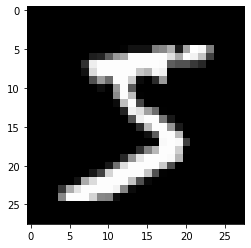

In [10]:
# plt.rcParams['cmap']
plt.imshow(x_train[0].reshape(28, 28), cmap='gray');

In [11]:
x_train, y_train, x_valid, y_valid = map(torch.tensor,
                                         (x_train, y_train, x_valid, y_valid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [12]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

# Matrix Multiplication

In [13]:
weights = torch.randn((784, 10))
bias = torch.zeros(10)
weights, bias

(tensor([[ 0.1772, -1.1550,  0.7991,  ...,  0.1661,  1.3536, -0.1229],
         [ 0.8387, -1.4871, -0.7861,  ..., -0.2279, -1.2122, -0.1899],
         [ 0.3033,  0.1960,  0.7538,  ..., -0.7052,  0.1714,  0.6972],
         ...,
         [-0.8308,  0.1347, -0.8541,  ...,  2.0758, -0.5505,  0.2423],
         [ 0.8823, -0.1719, -0.8483,  ...,  1.3032, -0.3801,  0.4371],
         [-1.5591,  1.3167,  0.5688,  ...,  0.6681,  0.9326, -1.4177]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [14]:
def matmult(a, b):
    rows_a, columns_a = a.shape
    rows_b, columns_b = b.shape
    assert columns_a == rows_b

    out = torch.zeros((rows_a, columns_b))
    for i in range(rows_a):
        for j in range(columns_b):
            for k in range(columns_a):
                out[i, j] += a[i, k] * b[k, j]
    return out

In [15]:
m1, m2 = x_train[:5], weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [16]:
%timeit -n 10 matmult(m1, m2)

757 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def matmult(a, b):
    rows_a, columns_a = a.shape
    rows_b, columns_b = b.shape
    assert columns_a == rows_b

    out = torch.zeros((rows_a, columns_b))
    for i in range(rows_a):
        for j in range(columns_b):
            # Utilize element-wise ops
            out[i, j] = (a[i, :] * b[:, j]).sum()
    return out

In [18]:
%timeit -n 10 t = matmult(m1, m2)

1.1 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
test_near(matmult(m1, m2), torch.matmul(m1, m2))

True

In [20]:
a = torch.tensor([10, 20, 30])
a

tensor([10, 20, 30])

In [21]:
a[None]

tensor([[10, 20, 30]])

In [22]:
a[None, :]

tensor([[10, 20, 30]])

In [23]:
a[:, None]

tensor([[10],
        [20],
        [30]])

In [24]:
a[..., None]

tensor([[10],
        [20],
        [30]])

In [25]:
a.unsqueeze(-1)

tensor([[10],
        [20],
        [30]])

In [26]:
a.unsqueeze(0)

tensor([[10, 20, 30]])

In [27]:
a.unsqueeze(-1).squeeze()

tensor([10, 20, 30])

In [28]:
m = torch.randn((3, 3))
m

tensor([[ 1.2345,  0.7041,  0.3273],
        [ 1.0294,  1.8673,  0.1992],
        [-1.1953,  1.5203, -2.1999]])

In [29]:
a.storage(), a.stride()

( 10
  20
  30
 [torch.LongStorage of size 3],
 (1,))

In [30]:
a_ = a.expand_as(m)
a_

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

In [31]:
a_.storage()

 10
 20
 30
[torch.LongStorage of size 3]

In [32]:
a_.stride()

(0, 1)

In [33]:
a_ = a[..., None].expand_as(m)
a_

tensor([[10, 10, 10],
        [20, 20, 20],
        [30, 30, 30]])

In [34]:
a_.storage()

 10
 20
 30
[torch.LongStorage of size 3]

In [35]:
a_.stride()

(1, 0)

In [36]:
def matmult(a, b):
    rows_a, columns_a = a.shape
    rows_b, columns_b = b.shape
    assert columns_a == rows_b

    out = torch.zeros((rows_a, columns_b))
    for i in range(rows_a):
        # Utilize broadcasting
        out[i] = (a[i][..., None] * b).sum(dim=0)
    return out

In [37]:
%timeit -n 10 matmult(m1, m2)

407 µs ± 145 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
test_near(matmult(m1, m2), torch.matmul(m1, m2))

True

In [39]:
def matmult(a, b):
    return torch.einsum('ik,kj->ij', m1, m2)

In [40]:
%timeit -n 10 t=matmult(m1, m2)

73.7 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
test_near(matmult(m1, m2), torch.matmul(m1, m2))

True

In [42]:
%timeit -n 10 t=torch.matmul(m1, m2)

The slowest run took 13.72 times longer than the fastest. This could mean that an intermediate result is being cached.
21.6 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
